# Autoencoder
https://www.kaggle.com/shivamb/how-autoencoders-work-intro-and-usecases

## Data

In [53]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler, MinMaxScaler

In [72]:
data = pd.read_csv("../data/creditcard.csv")

# rob_scaler = RobustScaler() # less prone to outliers than StandardScaler

# data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
# data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

# data.drop(['Time','Amount'], axis=1, inplace=True)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [73]:
X = data.drop('Class', axis=1)
y = data.Class

X_sca_MM = MinMaxScaler().fit_transform(X.values)
X_sca_R = RobustScaler().fit_transform(X.values)

## Create network

In [7]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

Using TensorFlow backend.


In [13]:
## input layer 
input_layer = Input(shape=(X.shape[1],)) # num_features

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [14]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

## Train Network

In [83]:
X_inp = X_sca_R # allows us to switch between different scaling methods

In [84]:
X_norm, X_fraud = X_inp[y == 0], X_inp[y == 1]

In [85]:
num_train_samples = 2000

autoencoder.fit(X_norm[:num_train_samples], X_norm[:num_train_samples], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 0s 95us/step - loss: 0.7754 - val_loss: 2.0622
Epoch 2/10
1600/1600 [==============================] - 0s 39us/step - loss: 0.7669 - val_loss: 2.0247
Epoch 3/10
1600/1600 [==============================] - 0s 42us/step - loss: 0.7564 - val_loss: 2.0065
Epoch 4/10
1600/1600 [==============================] - 0s 49us/step - loss: 0.7471 - val_loss: 2.0051
Epoch 5/10
1600/1600 [==============================] - 0s 104us/step - loss: 0.7410 - val_loss: 1.9635
Epoch 6/10
1600/1600 [==============================] - 0s 227us/step - loss: 0.7366 - val_loss: 1.9675
Epoch 7/10
1600/1600 [==============================] - 0s 94us/step - loss: 0.7282 - val_loss: 1.9482
Epoch 8/10
1600/1600 [==============================] - 0s 46us/step - loss: 0.7285 - val_loss: 1.9337
Epoch 9/10
1600/1600 [==============================] - 0s 39us/step - loss: 0.7196 - val_loss: 1.9216
Epoch 10/10
1600/1600 [=

## Get latent representation

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_cluster(X, y):
    fig = plt.figure(figsize=(12, 12))
    plt.scatter(X[:,0], X[:,1], cmap='coolwarm', c=(y==0), label='No Fraud', linewidth=2)
    plt.scatter(X[:,0], X[:,1], cmap='coolwarm', c=(y==1), label='Fraud', linewidth=2)
    plt.title('t-SNE', fontsize=14)
    plt.show()

In [87]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [88]:
norm_latent = hidden_representation.predict(X_norm[:3000])
fraud_latent = hidden_representation.predict(X_fraud)

In [89]:
rep_x = np.append(norm_latent, fraud_latent, axis = 0)
y_n = np.zeros(norm_latent.shape[0])
y_f = np.ones(fraud_latent.shape[0])
rep_y = np.append(y_n, y_f)

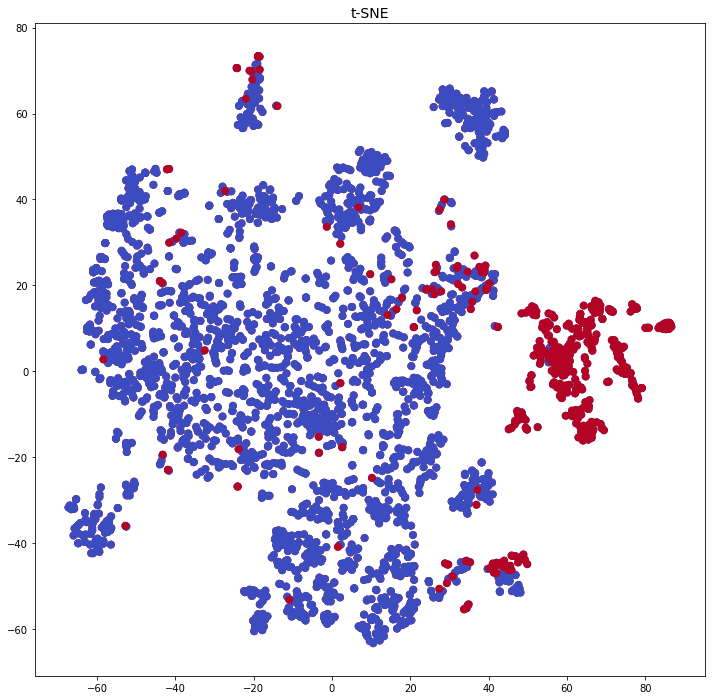

In [90]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, random_state=0).fit_transform(rep_x)
plot_cluster(X_tsne, rep_y)

## Classify

In [91]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [92]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       743
         1.0       0.95      0.78      0.86       130

    accuracy                           0.96       873
   macro avg       0.96      0.89      0.92       873
weighted avg       0.96      0.96      0.96       873


Accuracy Score:  0.9610538373424972
